### 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

# 1. 데이터 사용하기 쉽게 조작

### 데이터 불러오기

모든 데이터는 (2774,3) 형태입니다.  
2774는 sampling data개수이고, 3은 가속도, 전압, 그리고 전류 3개의 센서를 사용함을 의미합니다.  
정상 데이터 300개로 학습을 시킵니다. 따라서 trainset의 shape은 (300,2774,3)입니다.  
비정상 데이터의 유형은 3가지가 있습니다. 각각 misalign, shunting effect, tipwear입니다.  
마찬가지로 (2774,3)형태이고, 비정상 유형마다 100개의 data를 갖습니다.  
따라서 비정상 데이터 3유형은 각각 (100,2774,3)의 shape을 갖습니다.

In [2]:
# Normal 데이터 불러오기
for i in range(300):
    
    path1 = './SpotData/Normal/Spot_%d.csv'%(i+1)
    c1 = 'Normal_%d = pd.read_csv(path1, sep=",", header=None)'%(i+1)
    exec(c1)

# AbNormal 데이터 불러오기 (Shunt)
for i in range(100):

    path2 = './SpotData/Shunt/Spot_%d.csv'%(i+1)
    c2 = 'Shunt_%d = pd.read_csv(path2, sep=",", header=None)'%(i+1)

    exec(c2)

# AbNormal 데이터 불러오기 (Misalign)
for i in range(100):

    path3 = './SpotData/Misalign/Spot_%d.csv'%(i+1)
    c3 = 'Misalign_%d = pd.read_csv(path3, sep=",", header=None)'%(i+1)

    exec(c3)
    
# AbNormal 데이터 불러오기 (TipWear)
for i in range(100):

    path4 = './SpotData/TipWear/Spot_%d.csv'%(i+1)
    c4 = 'Tipwear_%d = pd.read_csv(path4, sep=",", header=None)'%(i+1)

    exec(c4)
    
    
    
    
print(Normal_100.shape, Shunt_100.shape)

(2774, 3) (2774, 3)


### 데이터 저장

In [3]:
for i in range(300):
    
    path1 = './FinalData/Normal_%d'%(i+1)
    c1 = 'Normal_%d.to_csv(path1, sep = ",", header = None, index = None)'%(i+1)
    exec(c1)
    
    
for i in range(100):
    path2 = './FinalData/Shunt_%d'%(i+1)
    c2 = 'Shunt_%d.to_csv(path2, sep = ",", header = None, index = None)'%(i+1)
    exec(c2)


for i in range(100):
    path3 = './FinalData/Misalign_%d'%(i+1)
    c3 = 'Misalign_%d.to_csv(path3, sep = ",", header = None, index = None)'%(i+1)
    exec(c3)

    
for i in range(100):
    path4 = './FinalData/TipWear_%d'%(i+1)
    c4 = 'Tipwear_%d.to_csv(path4, sep = ",", header = None, index = None)'%(i+1)
    exec(c4)



### 데이터 합치기

In [4]:
Train_Normal   = np.zeros((300,2774,3))
Test_Shunt     = np.zeros((100,2774,3))
Test_Misalign  = np.zeros((100,2774,3))
Test_Tipwear   = np.zeros((100,2774,3))
Test_Normal    = np.zeros((100,2774,3))



# 가속도에 대한 정상 학습데이터 300개
for i in range(300):
    path1 = './FinalData/Normal_%d'%(i+1)
    add1 = pd.read_csv(path1, sep = ",", header = None)
    Train_Normal[i,:,:]  = add1  

# 가속도에 대한 전체 고장 검증데이터 100개      
for i in range(100):
    path2 = './FinalData/Shunt_%d'%(i+1)
    add2 = pd.read_csv(path2, sep = ",", header = None)
    Test_Shunt[i,:,:] = add2

for i in range(100):        
    path3 = './FinalData/Misalign_%d'%(i+1)
    add3 = pd.read_csv(path3, sep = ",", header = None)
    Test_Misalign[i,:,:] = add3
    
for i in range(100):        
    path4 = './FinalData/TipWear_%d'%(i+1)
    add4 = pd.read_csv(path4, sep = ",", header = None)
    Test_Tipwear[i,:,:] = add4
    
# 가속도에 대한 전체 정상 검증데이터 100개    
for i in range(100):
    path5 = './SpotData/Normal/Spot_%d.csv'%(i+301)
    add5 = pd.read_csv(path5, sep = ",", header = None)
    Test_Normal[i,:,:] = add5
    

print(Train_Normal.shape,Test_Normal.shape)

(300, 2774, 3) (100, 2774, 3)


### 데이터 정규화

#### Train_Normal(300,2774,3), Test_Shunt, Test_Misalign, Test_Tipwear, Test_Normal(100,2774,3)

In [5]:
for i in range(300):
    for j in range(3):
        max_val = np.max(Train_Normal[i].T[j])
        min_val = np.min(Train_Normal[i].T[j])
        Train_Normal[i].T[j] = (Train_Normal[i].T[j] - min_val)/(max_val-min_val)

for i in range(100):
    for j in range(3):
        max_val = np.max(Test_Normal[i].T[j])
        min_val = np.min(Test_Normal[i].T[j])
        Test_Normal[i].T[j] = (Test_Normal[i].T[j] - min_val)/(max_val-min_val)

        max_val = np.max(Test_Shunt[i].T[j])
        min_val = np.min(Test_Shunt[i].T[j])
        Test_Shunt[i].T[j] = (Test_Shunt[i].T[j] - min_val)/(max_val-min_val)

        max_val = np.max(Test_Misalign[i].T[j])
        min_val = np.min(Test_Misalign[i].T[j])
        Test_Misalign[i].T[j] = (Test_Misalign[i].T[j] - min_val)/(max_val-min_val)

        max_val = np.max(Test_Tipwear[i].T[j])
        min_val = np.min(Test_Tipwear[i].T[j])
        Test_Tipwear[i].T[j] = (Test_Tipwear[i].T[j] - min_val)/(max_val-min_val)

        

## 모델 구축하기

In [6]:
# 오토인코더 모듈 정의
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        
        # encoder는 차원을 점차 줄여나감
        self.encoder = tf.keras.Sequential([layers.InputLayer(input_shape=(2774,3)),
                                            layers.Conv1D(filters = 128,kernel_size = 3,strides = 3,activation = 'relu'),
                                            layers.AveragePooling1D(pool_size = 3,strides = 3),
                                            layers.Conv1D(filters = 32,kernel_size = 3,strides = 3,activation = 'relu'),
                                            layers.AveragePooling1D(pool_size = 3,strides = 3),
                                            layers.Conv1D(filters = 16,kernel_size = 3,strides = 3, activation = 'relu')])
        # decoder는 차원을 점차 복원함.
        self.decoder = tf.keras.Sequential([layers.Conv1DTranspose(filters = 16, kernel_size =4,strides = 3,activation = 'relu'),
                                            layers.Conv1DTranspose(filters = 32,kernel_size = 3,strides = 3,activation = 'relu'),
                                            layers.Conv1DTranspose(filters = 64,kernel_size = 5,strides = 3,activation = 'relu'),
                                            layers.Conv1DTranspose(filters = 128,kernel_size = 3,strides = 3,activation = 'relu'),
                                            layers.Conv1DTranspose(filters = 3,kernel_size = 5,strides = 3,activation = 'sigmoid')])
                                            
        
    def call(self, x):
        encoded = self.encoder(x)        
        decoded = self.decoder(encoded)  
        return decoded

autoencoder = AnomalyDetector()

## 아래 3개의 cell 실행시 accuracy per epoch 확인 가능

In [7]:
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001), loss='mae')

epoch 1회마다 그 정확도를 기록하기 위한 리스트를 생성합니다.

In [8]:
s=0
normal_acc1=[]
normal_acc2=[]
misalign_acc1=[]
misalign_acc2=[]
shunt_acc1=[]
shunt_acc2=[]
tipwear_acc1=[]
tipwear_acc2=[]

### 코드의 로직은 다음과 같습니다.  
1회 학습을 시행합니다.  
학습된 최신의 모델에 test data를 적용시키고, reconstrucion error를 기준으로 이상을 탐지합니다.  
1에포크마다 모델의 정확도를 기록합니다.  
학습 중단 요건(충분한 반복수 or 충분한 정확도)이 만족되면 모델을 저장하고 학습이 종료됩니다.  
학습을 마친 후에는 기록한 data를 plotting하여 정확도의 추이를 확인합니다.

10/10 [==============================] - 0s 38ms/step - loss: 0.0190


10/10 [==============================] - 0s 34ms/step - loss: 0.0190


10/10 [==============================] - 0s 36ms/step - loss: 0.0188


10/10 [==============================] - 0s 33ms/step - loss: 0.0187


10/10 [==============================] - 0s 36ms/step - loss: 0.0185


10/10 [==============================] - 0s 34ms/step - loss: 0.0186


10/10 [==============================] - 0s 34ms/step - loss: 0.0186


10/10 [==============================] - 0s 35ms/step - loss: 0.0183


10/10 [==============================] - 0s 37ms/step - loss: 0.0183


10/10 [==============================] - 0s 31ms/step - loss: 0.0182


10/10 [==============================] - 0s 33ms/step - loss: 0.0181


INFO:tensorflow:Assets written to: ./MLModels/CNN1D_epoch2727\assets


INFO:tensorflow:Assets written to: ./MLModels/CNN1D_epoch2727\assets


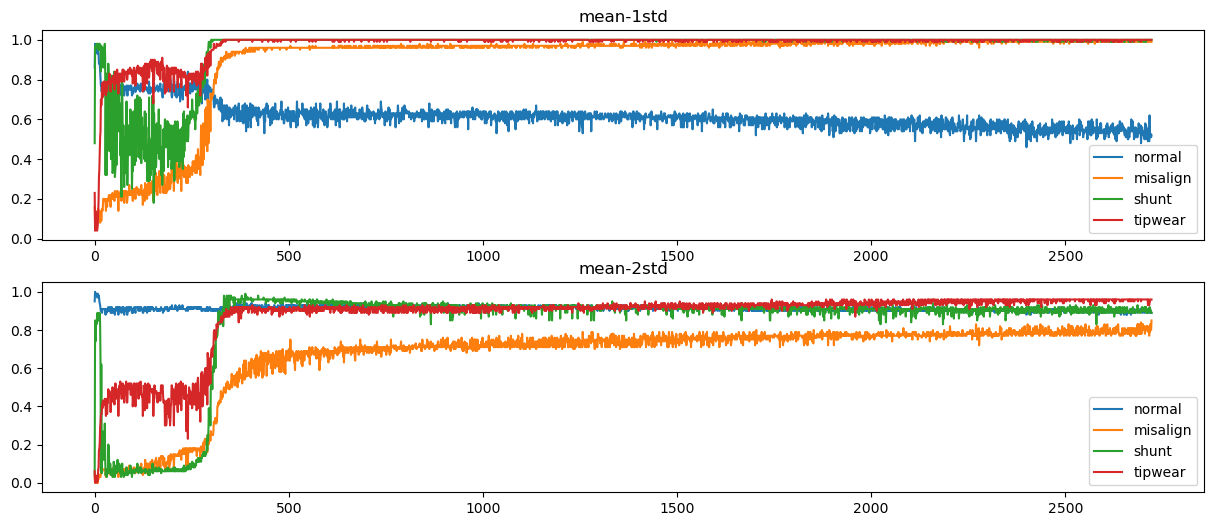

In [18]:
while True:
    s+=1
    history = autoencoder.fit(Train_Normal, Train_Normal,epochs=1,shuffle=True)
    
    encoded_train = autoencoder.encoder(Train_Normal).numpy()
    decoded_train = autoencoder.decoder(encoded_train).numpy()
    train_loss = tf.keras.losses.mae(decoded_train, Train_Normal)
    train_loss = np.sum(train_loss,axis=1)/2774

    encoded_normal = autoencoder.encoder(Test_Normal).numpy()
    decoded_normal = autoencoder.decoder(encoded_normal).numpy()
    normal_loss = tf.keras.losses.mae(decoded_normal, Test_Normal)
    normal_loss = np.sum(normal_loss,axis=1)/2774

    encoded_misalign = autoencoder.encoder(Test_Misalign).numpy()
    decoded_misalign = autoencoder.decoder(encoded_misalign).numpy()
    misalign_loss = tf.keras.losses.mae(decoded_misalign, Test_Misalign)
    misalign_loss = np.sum(misalign_loss,axis=1)/2774

    encoded_shunt = autoencoder.encoder(Test_Shunt).numpy()
    decoded_shunt = autoencoder.decoder(encoded_shunt).numpy()
    shunt_loss = tf.keras.losses.mae(decoded_shunt, Test_Shunt)
    shunt_loss = np.sum(shunt_loss,axis=1)/2774

    encoded_tipwear = autoencoder.encoder(Test_Tipwear).numpy()
    decoded_tipwear = autoencoder.decoder(encoded_tipwear).numpy()
    tipwear_loss = tf.keras.losses.mae(decoded_tipwear, Test_Tipwear)
    tipwear_loss = np.sum(tipwear_loss,axis=1)/2774
    
    
    threshold1 = np.mean(train_loss) + 1*np.std(train_loss)
    threshold2 = np.mean(train_loss) + 2*np.std(train_loss)
    
    s1=0
    s2=0
    for i in range(100):
        if normal_loss[i]<threshold1:
            s1+=1
        if normal_loss[i]<threshold2:
            s2+=1
    acc_normal1 = s1/100
    acc_normal2 = s2/100
    normal_acc1.append(acc_normal1)
    normal_acc2.append(acc_normal2)
    
    s1=0
    s2=0
    for i in range(100):
        if misalign_loss[i]>threshold1:
            s1+=1
        if misalign_loss[i]>threshold2:
            s2+=1
    acc_misalign1 = s1/100
    acc_misalign2 = s2/100
    misalign_acc1.append(acc_misalign1)
    misalign_acc2.append(acc_misalign2)
        
    s1=0
    s2=0
    for i in range(100):
        if shunt_loss[i]>threshold1:
            s1+=1
        if shunt_loss[i]>threshold2:
            s2+=1
    acc_shunt1 = s1/100
    acc_shunt2 = s2/100
    shunt_acc1.append(acc_shunt1)
    shunt_acc2.append(acc_shunt2)
        
    s1=0
    s2=0
    for i in range(100):
        if tipwear_loss[i]>threshold1:
            s1+=1
        if tipwear_loss[i]>threshold2:
            s2+=1
    acc_tipwear1 = s1/100
    acc_tipwear2 = s2/100
    tipwear_acc1.append(acc_tipwear1)
    tipwear_acc2.append(acc_tipwear2)
    
   
   
        
    
    a1 = (acc_normal1>0.84 and acc_misalign1>0.84 and acc_shunt1>0.85 and acc_tipwear1>0.84)
    b1 = (acc_normal1>0.94 and acc_misalign1>0.94  and acc_tipwear1>0.94)
    c1 = (acc_normal1>0.94 and  acc_shunt1>0.94 and acc_tipwear1>0.94)
    d1 = (acc_normal1>0.94 and  acc_misalign1>0.94 and acc_shunt1>0.94)
    
    a2 = (acc_normal2>0.84 and acc_misalign2>0.84 and acc_shunt2>0.85 and acc_tipwear2>0.84)
    b2 = (acc_normal2>0.94 and acc_misalign2>0.94  and acc_tipwear2>0.94)
    c2 = (acc_normal2>0.94 and  acc_shunt2>0.94 and acc_tipwear2>0.94)
    d2 = (acc_normal2>0.94 and  acc_misalign2>0.94 and acc_shunt2>0.94)
    
    if a1 or b1 or c1 or d1:
        model = autoencoder
        model.save('./MLModels/CNN1D_epoch%d'% s)
        break
    
    elif a2 or b2 or c2 or d2:
        model = autoencoder
        model.save('./MLModels/CNN1D_epoch%d'% s)
        break
        
    elif s==10000:
        model = autoencoder
        model.save('./MLModels/CNN1D_epoch%d'% s)
        break


모델의 학습을 중단케한, 마지막 정확도를 확인합니다.  
첫 줄은 이상탐지 threshold를 mean+1std로 설정하였을 때,  
두번째 줄은 threshold를 mean+2std로 설정하였을 때의 정확도를 나타냅니다.

In [21]:
print(acc_normal1,acc_misalign1,acc_shunt1,acc_tipwear1)
print(acc_normal2,acc_misalign2,acc_shunt2,acc_tipwear2)

0.52 0.99 1.0 1.0
0.89 0.85 0.89 0.96


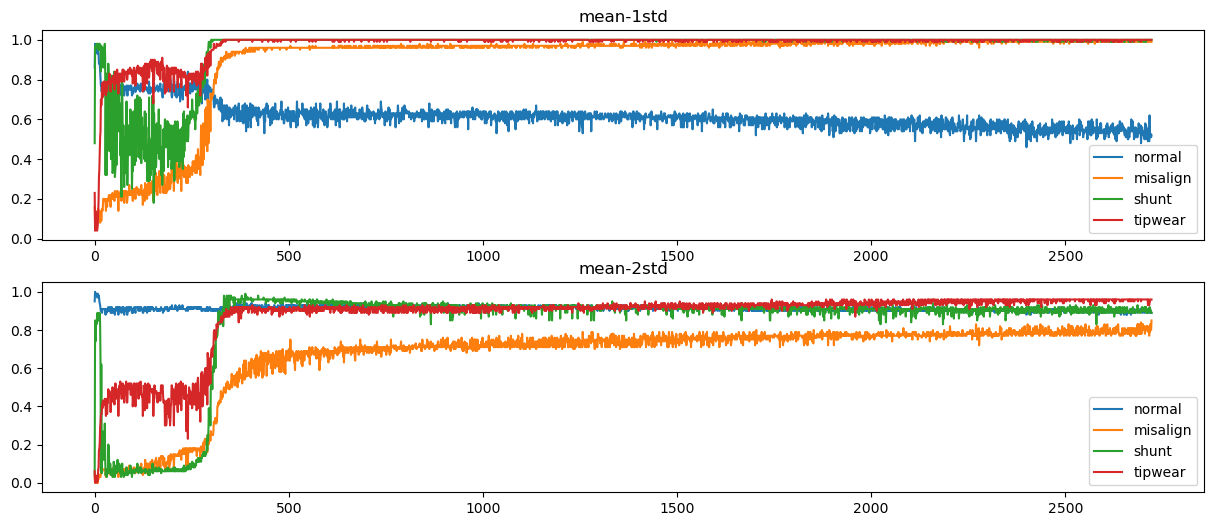

In [22]:
plt.figure(figsize=(15,6))

ax = plt.subplot(2,1,1)
plt.plot(normal_acc1,label="normal")
plt.plot(misalign_acc1,label="misalign")
plt.plot(shunt_acc1,label="shunt")
plt.plot(tipwear_acc1,label="tipwear")
plt.title('mean-1std')
plt.legend()

ax = plt.subplot(2,1,2)
plt.plot(normal_acc2,label="normal")
plt.plot(misalign_acc2,label="misalign")
plt.plot(shunt_acc2,label="shunt")
plt.plot(tipwear_acc2,label="tipwear")
plt.title('mean-2std')
plt.legend()

# Reconstruction 시각화

최종 모델은 input data를 어떻게 재구성하는지 확인합니다.

In [23]:
encoded_train = autoencoder.encoder(Train_Normal).numpy()
decoded_train = autoencoder.decoder(encoded_train).numpy()

encoded_normal = autoencoder.encoder(Test_Normal).numpy()
decoded_normal = autoencoder.decoder(encoded_normal).numpy()
error_normal = Test_Normal - decoded_normal 

encoded_misalign = autoencoder.encoder(Test_Misalign).numpy()
decoded_misalign = autoencoder.decoder(encoded_misalign).numpy()
error_misalign = Test_Misalign - decoded_misalign 

encoded_shunt = autoencoder.encoder(Test_Shunt).numpy()
decoded_shunt = autoencoder.decoder(encoded_shunt).numpy()
error_shunt = Test_Shunt - decoded_shunt 

encoded_tipwear = autoencoder.encoder(Test_Tipwear).numpy()
decoded_tipwear = autoencoder.decoder(encoded_tipwear).numpy()
error_tipwear = Test_Tipwear - decoded_tipwear 

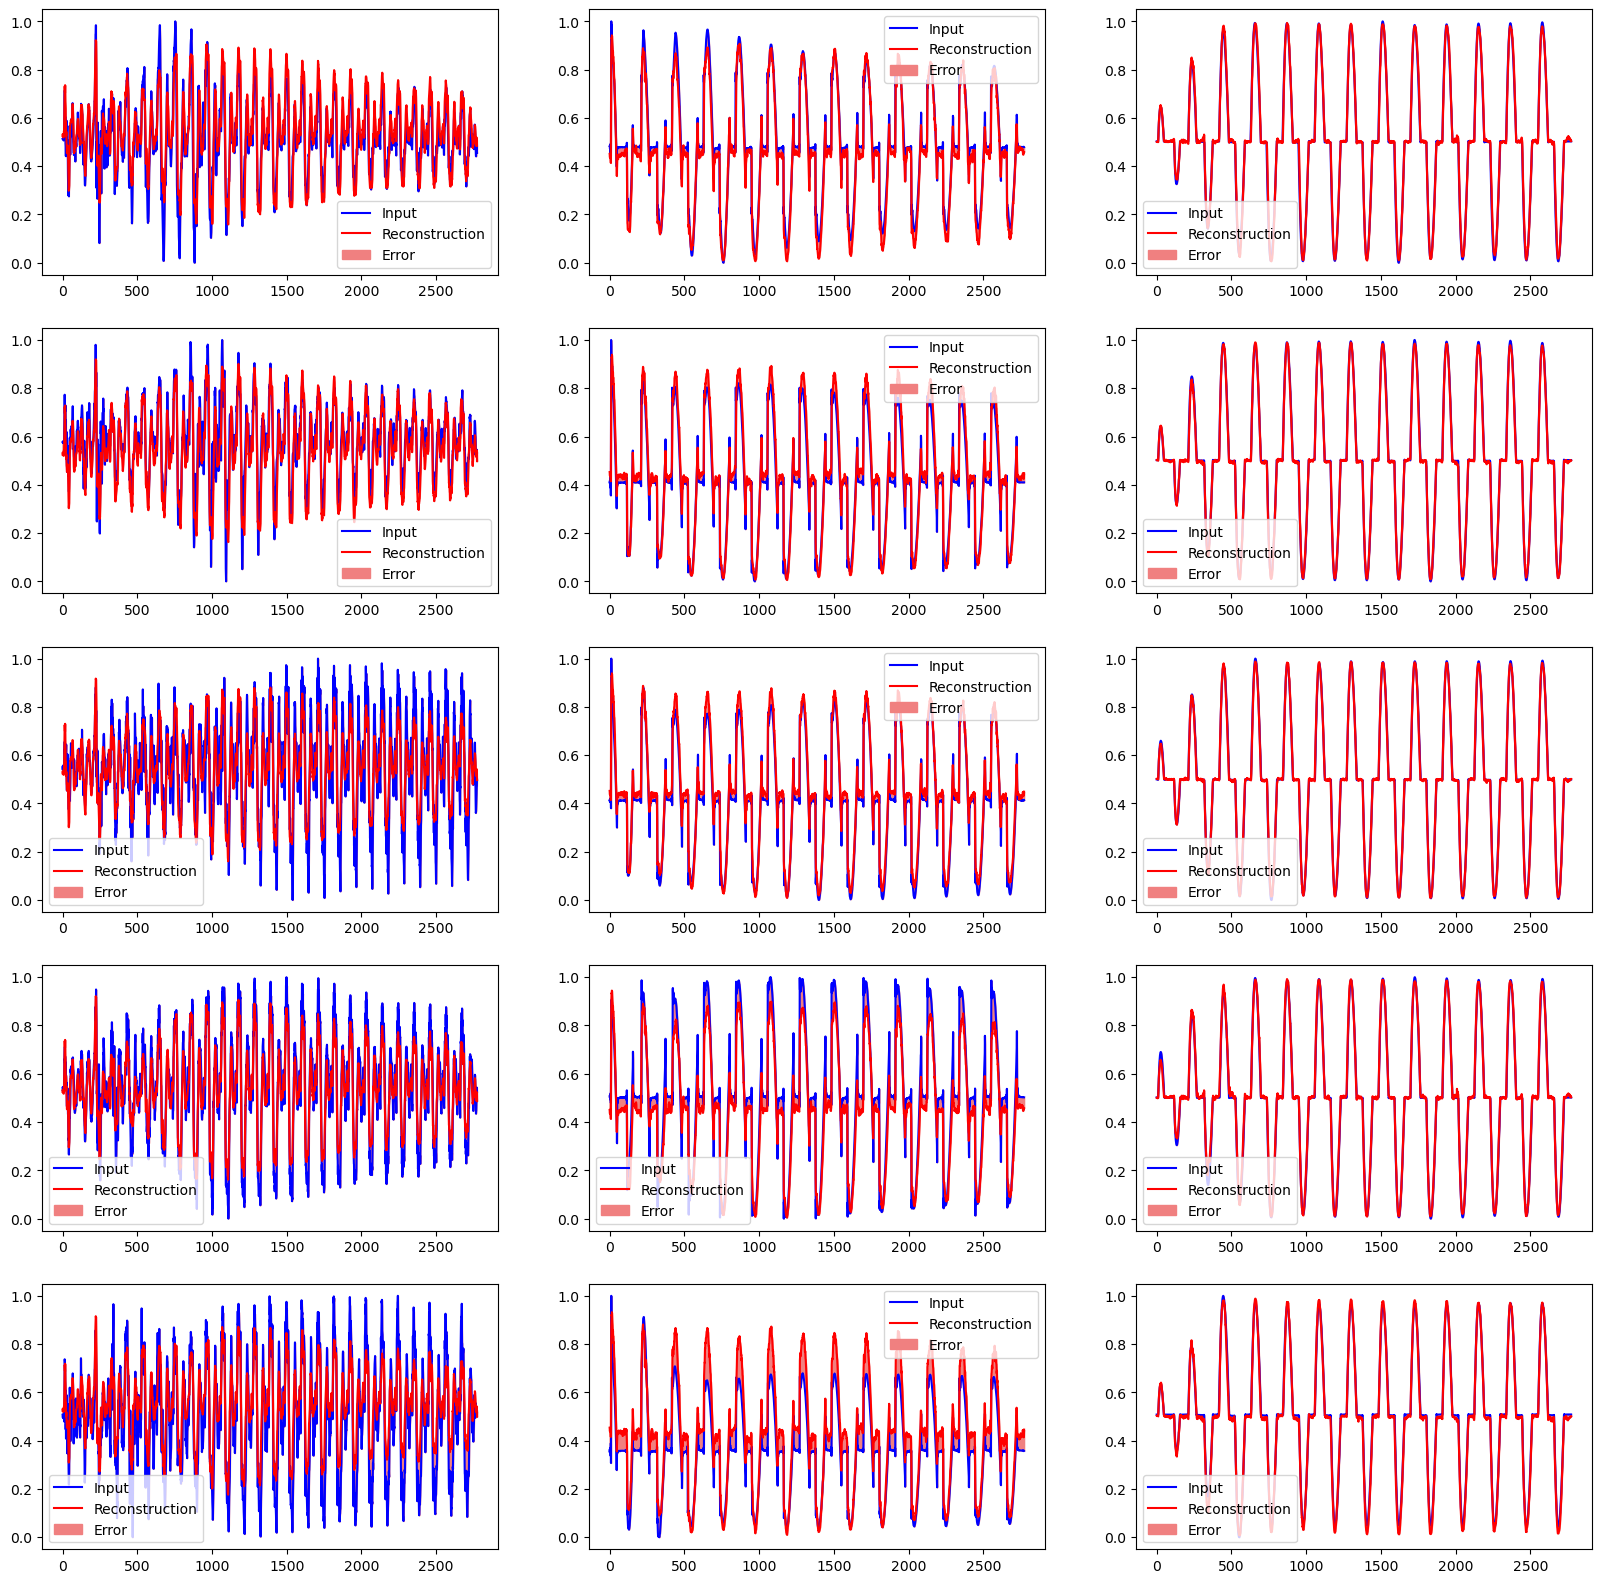

In [15]:
plt.figure(figsize=(20,20))

for i in range(3):
    show = plt.subplot(5,3,i+1)
    plt.plot(np.array(Train_Normal[0]).T[i], 'b')
    plt.plot(np.array(decoded_train[0]).T[i], 'r')
    plt.fill_between(np.arange(2774), np.array(decoded_train[0]).T[i],np.array(Train_Normal[0]).T[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    
    show = plt.subplot(5,3,i+4)
    plt.plot(np.array(Test_Normal[0]).T[i], 'b')
    plt.plot(np.array(decoded_normal[0]).T[i], 'r')
    plt.fill_between(np.arange(2774), np.array(decoded_normal[0]).T[i],np.array(Test_Normal[0]).T[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    
    show = plt.subplot(5,3,i+7)
    plt.plot(np.array(Test_Misalign[0]).T[i], 'b')
    plt.plot(np.array(decoded_misalign[0]).T[i], 'r')
    plt.fill_between(np.arange(2774), np.array(decoded_misalign[0]).T[i],np.array(Test_Misalign[0]).T[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    
    show = plt.subplot(5,3,i+10)
    plt.plot(np.array(Test_Shunt[0]).T[i], 'b')
    plt.plot(np.array(decoded_shunt[0]).T[i], 'r')
    plt.fill_between(np.arange(2774), np.array(decoded_shunt[0]).T[i],np.array(Test_Shunt[0]).T[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    
    show = plt.subplot(5,3,i+13)
    plt.plot(np.array(Test_Tipwear[0]).T[i], 'b')
    plt.plot(np.array(decoded_tipwear[0]).T[i], 'r')
    plt.fill_between(np.arange(2774), np.array(decoded_tipwear[0]).T[i],np.array(Test_Tipwear[0]).T[i], color='lightcoral')
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    
    
    

# 오류 발생 위치 확인

어떤 데이터는 가속도, 전압, 그리고 전류의 3개 영역을 갖습니다.  
데이터는 원본이 있고 재구성이 있으며, 원본과 재구성의 차가 바로 재구성오류(reconstruction error)입니다.  
어느 지점에서 가장 큰 재구성 오류가 발생하는지 산점도로 확인합니다.  
산점도의 점 하나는 data point 하나를 나타냅니다.

Normal data는 제법 규칙적인 오류 분포를 보입니다.  
특히 가속도 데이터의 240번째 value에서 주로 가장 큰 차이를 보이는데요,  
만약 어떤 데이터가 비정상으로 판별되었는데 가장 큰 오류가 발생한 위치가 240부근이라면,  
정상 데이터가 오분류되었을수도 있겠다는 추측을 할 수 있겠네요.

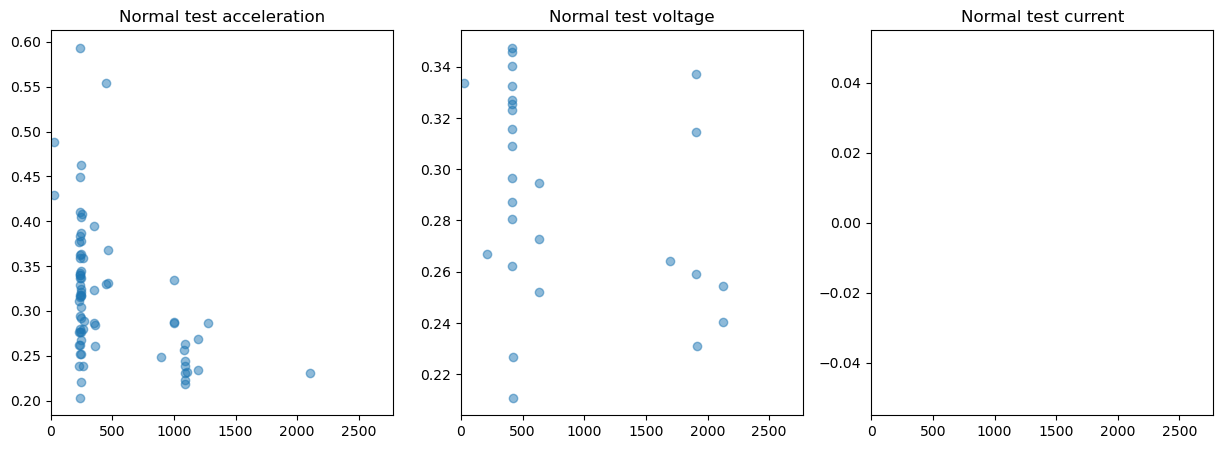

In [35]:
max_acc_x = []
max_acc_y = []
max_vol_x = []
max_vol_y = []
max_cur_x = []
max_cur_y = []

for i in range(100):
    temp = np.concatenate((error_normal[i].T[0],error_normal[i].T[1],error_normal[i].T[2]),axis=0)

    maxval = np.max(temp)  
    maxindex = np.where(temp == maxval)
    if maxindex[0][0]<2774:
        max_acc_x.append(maxindex[0][0])
        max_acc_y.append(maxval)
        
    elif maxindex[0][0]<5548:
        max_vol_x.append(maxindex[0][0]%2774)
        max_vol_y.append(maxval)
        
    else:
        max_cur_x.append(maxindex[0][0]%2774)
        max_cur_y.append(maxval)

plt.figure(figsize=(15,5))
        
plt.subplot(1,3,1)      
plt.scatter(max_acc_x,max_acc_y,alpha=0.5)
plt.title('Normal test acceleration')
plt.xlim(0,2774)

plt.subplot(1,3,2)   
plt.scatter(max_vol_x,max_vol_y,alpha=0.5)
plt.title('Normal test voltage')
plt.xlim(0,2774)

plt.subplot(1,3,3)
plt.scatter(max_cur_x,max_cur_y,alpha=0.5)
plt.title('Normal test current')
plt.xlim(0,2774)
plt.show()
    

    

misalign의 경우, 대부분 가속도 영역에서 큰 오차가 발생합니다.

(0.0, 2774.0)

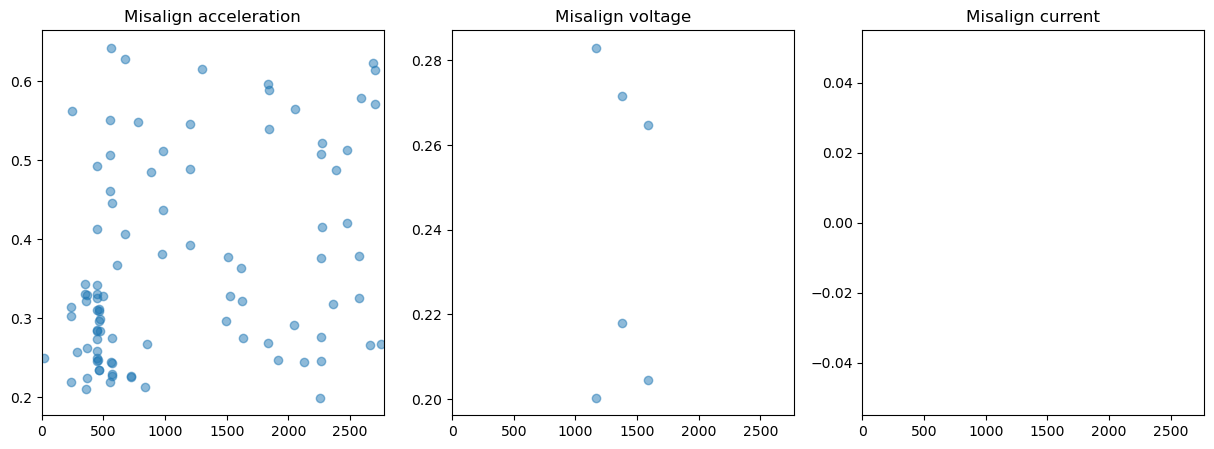

In [34]:
max_acc_x = []
max_acc_y = []
max_vol_x = []
max_vol_y = []
max_cur_x = []
max_cur_y = []

for i in range(100):
    temp = np.concatenate((error_misalign[i].T[0],error_misalign[i].T[1],error_misalign[i].T[2]),axis=0)

    maxval = np.max(temp)  
    maxindex = np.where(temp == maxval)
    if maxindex[0][0]<2774:
        max_acc_x.append(maxindex[0][0])
        max_acc_y.append(maxval)
        
    elif maxindex[0][0]<5548:
        max_vol_x.append(maxindex[0][0]%2774)
        max_vol_y.append(maxval)
        
    else:
        max_cur_x.append(maxindex[0][0]%2774)
        max_cur_y.append(maxval)

plt.figure(figsize=(15,5))
        
plt.subplot(1,3,1)      
plt.scatter(max_acc_x,max_acc_y,alpha=0.5)
plt.title('Misalign acceleration')
plt.xlim(0,2774)

plt.subplot(1,3,2)   
plt.scatter(max_vol_x,max_vol_y,alpha=0.5)
plt.title('Misalign voltage')
plt.xlim(0,2774)

plt.subplot(1,3,3)
plt.scatter(max_cur_x,max_cur_y,alpha=0.5)
plt.title('Misalign current')
plt.xlim(0,2774)

shunting effect는 normal data의 경우와 오류 분포 양상이 흡사합니다.  
이는 shunting effect와 normal의 가속도를 plotting한 그래프가 비슷한 모양을 가진다는 점에서  
충분히 예측할 수 있는 점입니다.

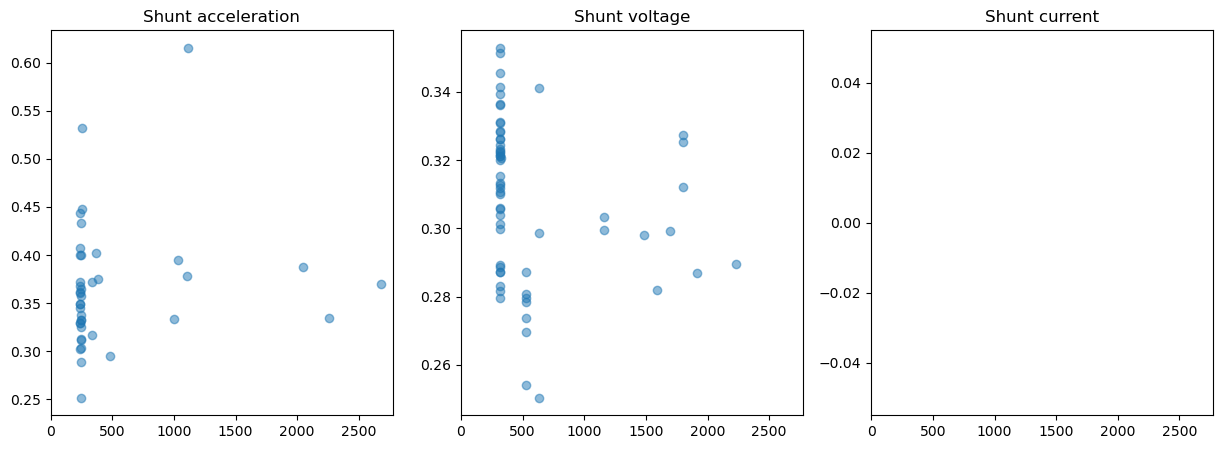

In [32]:
max_acc_x = []
max_acc_y = []
max_vol_x = []
max_vol_y = []
max_cur_x = []
max_cur_y = []

for i in range(100):
    temp = np.concatenate((error_shunt[i].T[0],error_shunt[i].T[1],error_shunt[i].T[2]),axis=0)

    maxval = np.max(temp)  
    maxindex = np.where(temp == maxval)
    if maxindex[0][0]<2774:
        max_acc_x.append(maxindex[0][0])
        max_acc_y.append(maxval)
        
    elif maxindex[0][0]<5548:
        max_vol_x.append(maxindex[0][0]%2774)
        max_vol_y.append(maxval)
        
    else:
        max_cur_x.append(maxindex[0][0]%2774)
        max_cur_y.append(maxval)

plt.figure(figsize=(15,5))
        
plt.subplot(1,3,1)      
plt.scatter(max_acc_x,max_acc_y,alpha=0.5)
plt.title('Shunt acceleration')
plt.xlim(0,2774)

plt.subplot(1,3,2)   
plt.scatter(max_vol_x,max_vol_y,alpha=0.5)
plt.title('Shunt voltage')
plt.xlim(0,2774)

plt.subplot(1,3,3)
plt.scatter(max_cur_x,max_cur_y,alpha=0.5)
plt.title('Shunt current')
plt.xlim(0,2774)

plt.show()

Tipwear는 오류가 가속도 영역에 주로 분포하고 있음을 확인할 수 있습니다.

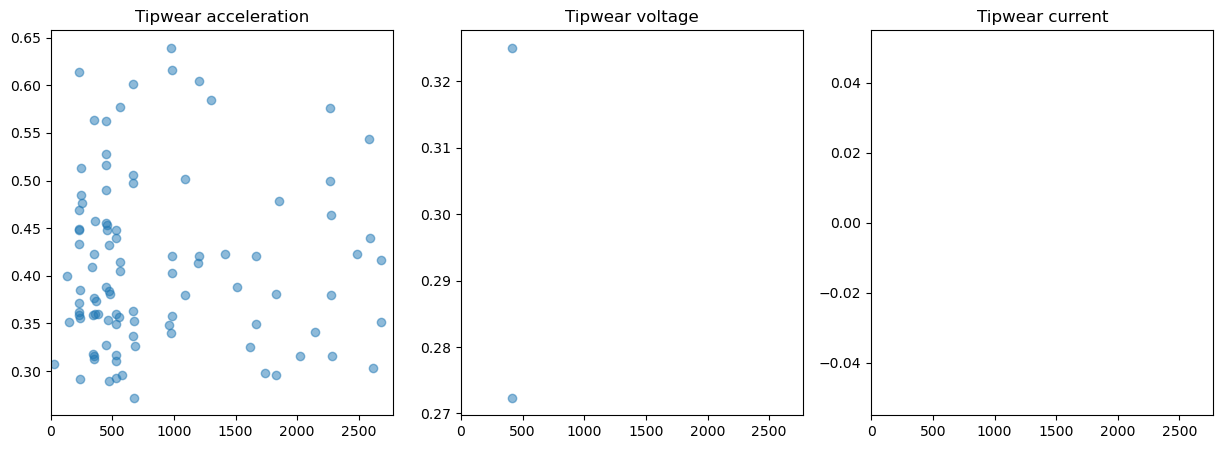

In [33]:
max_acc_x = []
max_acc_y = []
max_vol_x = []
max_vol_y = []
max_cur_x = []
max_cur_y = []

for i in range(100):
    temp = np.concatenate((error_tipwear[i].T[0],error_tipwear[i].T[1],error_tipwear[i].T[2]),axis=0)

    maxval = np.max(temp)  
    maxindex = np.where(temp == maxval)
    if maxindex[0][0]<2774:
        max_acc_x.append(maxindex[0][0])
        max_acc_y.append(maxval)
        
    elif maxindex[0][0]<5548:
        max_vol_x.append(maxindex[0][0]%2774)
        max_vol_y.append(maxval)
        
    else:
        max_cur_x.append(maxindex[0][0]%2774)
        max_cur_y.append(maxval)

plt.figure(figsize=(15,5))
        
plt.subplot(1,3,1)      
plt.scatter(max_acc_x,max_acc_y,alpha=0.5)
plt.title('Tipwear acceleration')
plt.xlim(0,2774)

plt.subplot(1,3,2)   
plt.scatter(max_vol_x,max_vol_y,alpha=0.5)
plt.title('Tipwear voltage')
plt.xlim(0,2774)

plt.subplot(1,3,3)
plt.scatter(max_cur_x,max_cur_y,alpha=0.5)
plt.title('Tipwear current')
plt.xlim(0,2774)

plt.show()

3가지 비정상 타입(misalign,shunt,tipwear)모두 전류 영역에서는 큰 오차를 보이지 않는데요,  
이는 전류가 정상과 비정상을 판가름하는 중요한 요소가 아닐 수도 있다는 점을 시사합니다.